<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:09:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


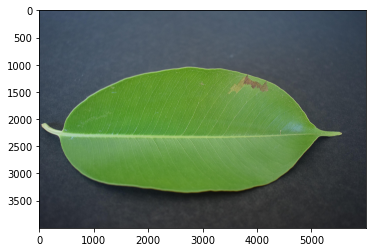

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

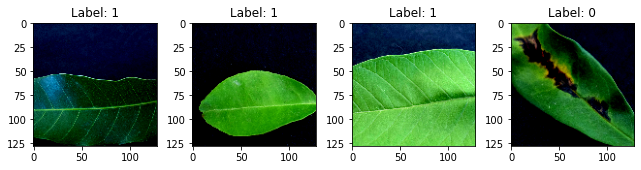

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:10:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2614984968533247 samples/sec                   batch loss = 1.0886681079864502 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2681426073271953 samples/sec                   batch loss = 0.5625685453414917 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2703727625651855 samples/sec                   batch loss = 0.7119560837745667 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.268298295503726 samples/sec                   batch loss = 0.7767106294631958 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.269514533662019 samples/sec                   batch loss = 0.6967650651931763 | accuracy = 0.5


Epoch[1] Batch[30] Speed: 1.2684135523824163 samples/sec                   batch loss = 0.5925718545913696 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2752275286892096 samples/sec                   batch loss = 0.9912607073783875 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.269137406921729 samples/sec                   batch loss = 1.0172375440597534 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.2696161762925293 samples/sec                   batch loss = 0.7142189741134644 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.271022588410199 samples/sec                   batch loss = 0.5616859793663025 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2702008893335919 samples/sec                   batch loss = 0.9686247110366821 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.270990524246349 samples/sec                   batch loss = 1.3973734378814697 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.2650393309289576 samples/sec                   batch loss = 0.7319938540458679 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2719780334337059 samples/sec                   batch loss = 0.749575138092041 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2672552248773115 samples/sec                   batch loss = 1.3075138330459595 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2649149588046547 samples/sec                   batch loss = 0.3323076069355011 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.270346406291787 samples/sec                   batch loss = 0.7199786901473999 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2647238701665378 samples/sec                   batch loss = 0.8107024431228638 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.269286521420457 samples/sec                   batch loss = 0.869265079498291 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2698085540565762 samples/sec                   batch loss = 0.6718071103096008 | accuracy = 0.6125


Epoch[1] Batch[105] Speed: 1.2676592014990782 samples/sec                   batch loss = 0.5976512432098389 | accuracy = 0.6142857142857143


Epoch[1] Batch[110] Speed: 1.274415680679007 samples/sec                   batch loss = 0.6461795568466187 | accuracy = 0.6113636363636363


Epoch[1] Batch[115] Speed: 1.2683963871770005 samples/sec                   batch loss = 0.5666396617889404 | accuracy = 0.6152173913043478


Epoch[1] Batch[120] Speed: 1.2723899486356056 samples/sec                   batch loss = 0.6418468356132507 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.2725692681171155 samples/sec                   batch loss = 0.5395702123641968 | accuracy = 0.612


Epoch[1] Batch[130] Speed: 1.2647551421996324 samples/sec                   batch loss = 0.3316848874092102 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.2665409729448982 samples/sec                   batch loss = 0.18460360169410706 | accuracy = 0.6129629629629629


Epoch[1] Batch[140] Speed: 1.2762574591294022 samples/sec                   batch loss = 0.5379003286361694 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2729847538194363 samples/sec                   batch loss = 0.661673367023468 | accuracy = 0.6137931034482759


Epoch[1] Batch[150] Speed: 1.2669104351086968 samples/sec                   batch loss = 0.5685629844665527 | accuracy = 0.6183333333333333


Epoch[1] Batch[155] Speed: 1.271084025171337 samples/sec                   batch loss = 0.5561223030090332 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2708175212249624 samples/sec                   batch loss = 0.4790860414505005 | accuracy = 0.6265625


Epoch[1] Batch[165] Speed: 1.2719500675996707 samples/sec                   batch loss = 0.8138642311096191 | accuracy = 0.6287878787878788


Epoch[1] Batch[170] Speed: 1.2708919346707688 samples/sec                   batch loss = 1.2584062814712524 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2644388701758231 samples/sec                   batch loss = 0.2820890247821808 | accuracy = 0.6328571428571429


Epoch[1] Batch[180] Speed: 1.2735452151692108 samples/sec                   batch loss = 0.47557997703552246 | accuracy = 0.6402777777777777


Epoch[1] Batch[185] Speed: 1.2628924856267567 samples/sec                   batch loss = 0.7949864268302917 | accuracy = 0.6391891891891892


Epoch[1] Batch[190] Speed: 1.276557234064716 samples/sec                   batch loss = 0.3782322108745575 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2733922955634724 samples/sec                   batch loss = 0.6453199982643127 | accuracy = 0.6371794871794871


Epoch[1] Batch[200] Speed: 1.2718444835545508 samples/sec                   batch loss = 0.5130953192710876 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.274052471270779 samples/sec                   batch loss = 0.3106793463230133 | accuracy = 0.6414634146341464


Epoch[1] Batch[210] Speed: 1.2698838105712285 samples/sec                   batch loss = 0.8540341258049011 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.2711491276560667 samples/sec                   batch loss = 0.4637632966041565 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2719409066455762 samples/sec                   batch loss = 0.4982583522796631 | accuracy = 0.6465909090909091


Epoch[1] Batch[225] Speed: 1.273924095845969 samples/sec                   batch loss = 0.5385749340057373 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.273224532232421 samples/sec                   batch loss = 0.5486057996749878 | accuracy = 0.65


Epoch[1] Batch[235] Speed: 1.2696229978835853 samples/sec                   batch loss = 0.3184388279914856 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2708797083187955 samples/sec                   batch loss = 0.570008397102356 | accuracy = 0.65


Epoch[1] Batch[245] Speed: 1.2786952765938442 samples/sec                   batch loss = 0.6029984951019287 | accuracy = 0.6520408163265307


Epoch[1] Batch[250] Speed: 1.2684488432027041 samples/sec                   batch loss = 0.3773602545261383 | accuracy = 0.654


Epoch[1] Batch[255] Speed: 1.267910584018834 samples/sec                   batch loss = 0.37492942810058594 | accuracy = 0.6558823529411765


Epoch[1] Batch[260] Speed: 1.2702713834717991 samples/sec                   batch loss = 0.4710439443588257 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.2698150893899864 samples/sec                   batch loss = 1.0004981756210327 | accuracy = 0.6490566037735849


Epoch[1] Batch[270] Speed: 1.2709380503514371 samples/sec                   batch loss = 0.7588181495666504 | accuracy = 0.6472222222222223


Epoch[1] Batch[275] Speed: 1.2791491987064878 samples/sec                   batch loss = 0.7418830394744873 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2747058743528636 samples/sec                   batch loss = 0.5486046075820923 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2759077540532955 samples/sec                   batch loss = 0.549986720085144 | accuracy = 0.6473684210526316


Epoch[1] Batch[290] Speed: 1.2663621056076693 samples/sec                   batch loss = 0.6769042611122131 | accuracy = 0.65


Epoch[1] Batch[295] Speed: 1.2711758061921687 samples/sec                   batch loss = 0.6203953623771667 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2737273746810218 samples/sec                   batch loss = 1.4110336303710938 | accuracy = 0.6458333333333334


Epoch[1] Batch[305] Speed: 1.2677853593041228 samples/sec                   batch loss = 0.2581193149089813 | accuracy = 0.648360655737705


Epoch[1] Batch[310] Speed: 1.2701275183434426 samples/sec                   batch loss = 1.5558291673660278 | accuracy = 0.6483870967741936


Epoch[1] Batch[315] Speed: 1.2725722604208953 samples/sec                   batch loss = 0.8463633060455322 | accuracy = 0.6460317460317461


Epoch[1] Batch[320] Speed: 1.275639223732165 samples/sec                   batch loss = 0.8638613224029541 | accuracy = 0.646875


Epoch[1] Batch[325] Speed: 1.2720084115088706 samples/sec                   batch loss = 0.8292028903961182 | accuracy = 0.6430769230769231


Epoch[1] Batch[330] Speed: 1.2664061724523028 samples/sec                   batch loss = 0.7338967323303223 | accuracy = 0.6439393939393939


Epoch[1] Batch[335] Speed: 1.2678476332316746 samples/sec                   batch loss = 0.688269853591919 | accuracy = 0.6440298507462686


Epoch[1] Batch[340] Speed: 1.269634911824056 samples/sec                   batch loss = 0.47039932012557983 | accuracy = 0.6441176470588236


Epoch[1] Batch[345] Speed: 1.2723078337116511 samples/sec                   batch loss = 0.8006304502487183 | accuracy = 0.644927536231884


Epoch[1] Batch[350] Speed: 1.274351985508563 samples/sec                   batch loss = 0.660236120223999 | accuracy = 0.6464285714285715


Epoch[1] Batch[355] Speed: 1.271684935453554 samples/sec                   batch loss = 0.5475371479988098 | accuracy = 0.647887323943662


Epoch[1] Batch[360] Speed: 1.2746363397735436 samples/sec                   batch loss = 0.4820593595504761 | accuracy = 0.65


Epoch[1] Batch[365] Speed: 1.2754822130414838 samples/sec                   batch loss = 0.554816484451294 | accuracy = 0.6534246575342466


Epoch[1] Batch[370] Speed: 1.275450990075375 samples/sec                   batch loss = 0.7045024037361145 | accuracy = 0.6533783783783784


Epoch[1] Batch[375] Speed: 1.2620012312195392 samples/sec                   batch loss = 0.6487025618553162 | accuracy = 0.652


Epoch[1] Batch[380] Speed: 1.265040857119181 samples/sec                   batch loss = 0.5902937054634094 | accuracy = 0.6519736842105263


Epoch[1] Batch[385] Speed: 1.269009252143605 samples/sec                   batch loss = 0.5460910797119141 | accuracy = 0.6532467532467533


Epoch[1] Batch[390] Speed: 1.2715612770655196 samples/sec                   batch loss = 0.4398578703403473 | accuracy = 0.6544871794871795


Epoch[1] Batch[395] Speed: 1.2685766929689228 samples/sec                   batch loss = 1.1727153062820435 | accuracy = 0.6544303797468355


Epoch[1] Batch[400] Speed: 1.2634763490017595 samples/sec                   batch loss = 0.5439170598983765 | accuracy = 0.65625


Epoch[1] Batch[405] Speed: 1.267054146477035 samples/sec                   batch loss = 0.48527997732162476 | accuracy = 0.658641975308642


Epoch[1] Batch[410] Speed: 1.2698147049567472 samples/sec                   batch loss = 0.39876943826675415 | accuracy = 0.6585365853658537


Epoch[1] Batch[415] Speed: 1.2690902698330908 samples/sec                   batch loss = 0.9077857732772827 | accuracy = 0.6596385542168675


Epoch[1] Batch[420] Speed: 1.2718104496944684 samples/sec                   batch loss = 0.5312533378601074 | accuracy = 0.6601190476190476


Epoch[1] Batch[425] Speed: 1.2740184158862895 samples/sec                   batch loss = 0.5011018514633179 | accuracy = 0.6611764705882353


Epoch[1] Batch[430] Speed: 1.266946216382596 samples/sec                   batch loss = 0.5665239095687866 | accuracy = 0.6633720930232558


Epoch[1] Batch[435] Speed: 1.2747538169560058 samples/sec                   batch loss = 0.8403286933898926 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.2657209503354454 samples/sec                   batch loss = 0.4382505416870117 | accuracy = 0.6647727272727273


Epoch[1] Batch[445] Speed: 1.2674792521598506 samples/sec                   batch loss = 0.535237193107605 | accuracy = 0.6657303370786517


Epoch[1] Batch[450] Speed: 1.2666443394252074 samples/sec                   batch loss = 0.6169027090072632 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.2708755687411206 samples/sec                   batch loss = 0.38569414615631104 | accuracy = 0.6692307692307692


Epoch[1] Batch[460] Speed: 1.2640046590595315 samples/sec                   batch loss = 0.569995105266571 | accuracy = 0.6711956521739131


Epoch[1] Batch[465] Speed: 1.2675826760843993 samples/sec                   batch loss = 0.387581467628479 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.2709880208061477 samples/sec                   batch loss = 0.6895212531089783 | accuracy = 0.673936170212766


Epoch[1] Batch[475] Speed: 1.2735887198704154 samples/sec                   batch loss = 0.27265051007270813 | accuracy = 0.6752631578947368


Epoch[1] Batch[480] Speed: 1.2708515982285116 samples/sec                   batch loss = 0.24060368537902832 | accuracy = 0.6755208333333333


Epoch[1] Batch[485] Speed: 1.2731904244745682 samples/sec                   batch loss = 0.823045015335083 | accuracy = 0.6757731958762887


Epoch[1] Batch[490] Speed: 1.271495168729185 samples/sec                   batch loss = 0.8330494165420532 | accuracy = 0.6770408163265306


Epoch[1] Batch[495] Speed: 1.2710846992753235 samples/sec                   batch loss = 0.49476906657218933 | accuracy = 0.6767676767676768


Epoch[1] Batch[500] Speed: 1.2702049283498413 samples/sec                   batch loss = 0.38042834401130676 | accuracy = 0.6775


Epoch[1] Batch[505] Speed: 1.2719597108518064 samples/sec                   batch loss = 1.737241506576538 | accuracy = 0.6777227722772278


Epoch[1] Batch[510] Speed: 1.2725209105783604 samples/sec                   batch loss = 0.7914958596229553 | accuracy = 0.6784313725490196


Epoch[1] Batch[515] Speed: 1.2721069814776875 samples/sec                   batch loss = 0.541294276714325 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.2633861520894927 samples/sec                   batch loss = 0.7996434569358826 | accuracy = 0.676923076923077


Epoch[1] Batch[525] Speed: 1.2609657398583831 samples/sec                   batch loss = 0.359508752822876 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.257345770281681 samples/sec                   batch loss = 0.9355392456054688 | accuracy = 0.6778301886792453


Epoch[1] Batch[535] Speed: 1.2552881427937908 samples/sec                   batch loss = 0.23110410571098328 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.2641994360644473 samples/sec                   batch loss = 0.4862854480743408 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.265410971560939 samples/sec                   batch loss = 0.2962660491466522 | accuracy = 0.6784403669724771


Epoch[1] Batch[550] Speed: 1.265304657184307 samples/sec                   batch loss = 0.44859522581100464 | accuracy = 0.6781818181818182


Epoch[1] Batch[555] Speed: 1.2670260139891405 samples/sec                   batch loss = 1.0874325037002563 | accuracy = 0.6783783783783783


Epoch[1] Batch[560] Speed: 1.2707406140271083 samples/sec                   batch loss = 0.11816756427288055 | accuracy = 0.6790178571428571


Epoch[1] Batch[565] Speed: 1.2653394889216532 samples/sec                   batch loss = 0.3153582513332367 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.2720589484104359 samples/sec                   batch loss = 0.7305070161819458 | accuracy = 0.6780701754385965


Epoch[1] Batch[575] Speed: 1.2653578121395102 samples/sec                   batch loss = 0.6997736096382141 | accuracy = 0.6791304347826087


Epoch[1] Batch[580] Speed: 1.268359948616094 samples/sec                   batch loss = 0.42798933386802673 | accuracy = 0.6793103448275862


Epoch[1] Batch[585] Speed: 1.2674845187111154 samples/sec                   batch loss = 1.1242448091506958 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.267719355619679 samples/sec                   batch loss = 0.5048315525054932 | accuracy = 0.6792372881355933


Epoch[1] Batch[595] Speed: 1.26873488637229 samples/sec                   batch loss = 0.70688796043396 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.2665615301515067 samples/sec                   batch loss = 0.10975795984268188 | accuracy = 0.6804166666666667


Epoch[1] Batch[605] Speed: 1.2687259635598946 samples/sec                   batch loss = 0.3729867935180664 | accuracy = 0.6797520661157025


Epoch[1] Batch[610] Speed: 1.2694448919177346 samples/sec                   batch loss = 0.6422774791717529 | accuracy = 0.6795081967213115


Epoch[1] Batch[615] Speed: 1.270024544004077 samples/sec                   batch loss = 0.7661401629447937 | accuracy = 0.6796747967479675


Epoch[1] Batch[620] Speed: 1.2713109496980477 samples/sec                   batch loss = 0.7524582147598267 | accuracy = 0.6774193548387096


Epoch[1] Batch[625] Speed: 1.2688399547316525 samples/sec                   batch loss = 0.42619290947914124 | accuracy = 0.6788


Epoch[1] Batch[630] Speed: 1.2713732814383483 samples/sec                   batch loss = 0.28376495838165283 | accuracy = 0.678968253968254


Epoch[1] Batch[635] Speed: 1.2707856599172307 samples/sec                   batch loss = 0.7144784927368164 | accuracy = 0.6795275590551181


Epoch[1] Batch[640] Speed: 1.2684545014244886 samples/sec                   batch loss = 0.5316628217697144 | accuracy = 0.680078125


Epoch[1] Batch[645] Speed: 1.2711550989278853 samples/sec                   batch loss = 0.23452533781528473 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.2742700042890327 samples/sec                   batch loss = 0.7628186345100403 | accuracy = 0.6811538461538461


Epoch[1] Batch[655] Speed: 1.2674953392174115 samples/sec                   batch loss = 0.6112796068191528 | accuracy = 0.6820610687022901


Epoch[1] Batch[660] Speed: 1.2716953458308113 samples/sec                   batch loss = 0.7749704122543335 | accuracy = 0.6818181818181818


Epoch[1] Batch[665] Speed: 1.2677715640617648 samples/sec                   batch loss = 0.45616960525512695 | accuracy = 0.6827067669172933


Epoch[1] Batch[670] Speed: 1.2709669345281294 samples/sec                   batch loss = 0.58673495054245 | accuracy = 0.6835820895522388


Epoch[1] Batch[675] Speed: 1.2779686585211465 samples/sec                   batch loss = 0.17277419567108154 | accuracy = 0.6840740740740741


Epoch[1] Batch[680] Speed: 1.265823036943268 samples/sec                   batch loss = 0.2413550317287445 | accuracy = 0.6834558823529412


Epoch[1] Batch[685] Speed: 1.2777694212244388 samples/sec                   batch loss = 0.2862064838409424 | accuracy = 0.6843065693430657


Epoch[1] Batch[690] Speed: 1.268404538194271 samples/sec                   batch loss = 1.0083657503128052 | accuracy = 0.6851449275362319


Epoch[1] Batch[695] Speed: 1.2684734904021562 samples/sec                   batch loss = 0.12378977984189987 | accuracy = 0.6870503597122302


Epoch[1] Batch[700] Speed: 1.2721045700926508 samples/sec                   batch loss = 0.368251234292984 | accuracy = 0.6864285714285714


Epoch[1] Batch[705] Speed: 1.2683602362807442 samples/sec                   batch loss = 0.34859785437583923 | accuracy = 0.6868794326241134


Epoch[1] Batch[710] Speed: 1.2665476659156458 samples/sec                   batch loss = 0.9854942560195923 | accuracy = 0.6862676056338028


Epoch[1] Batch[715] Speed: 1.2673683774773778 samples/sec                   batch loss = 0.2623231112957001 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2742946846561918 samples/sec                   batch loss = 0.48259517550468445 | accuracy = 0.6875


Epoch[1] Batch[725] Speed: 1.269198661567545 samples/sec                   batch loss = 0.44514235854148865 | accuracy = 0.6875862068965517


Epoch[1] Batch[730] Speed: 1.2700356002057829 samples/sec                   batch loss = 0.6754598617553711 | accuracy = 0.6873287671232877


Epoch[1] Batch[735] Speed: 1.2659181670688648 samples/sec                   batch loss = 0.42604929208755493 | accuracy = 0.6877551020408164


Epoch[1] Batch[740] Speed: 1.2722665390245693 samples/sec                   batch loss = 0.4675988554954529 | accuracy = 0.6891891891891891


Epoch[1] Batch[745] Speed: 1.269486291812982 samples/sec                   batch loss = 1.2255785465240479 | accuracy = 0.6895973154362416


Epoch[1] Batch[750] Speed: 1.2748855566148436 samples/sec                   batch loss = 0.4685805141925812 | accuracy = 0.6893333333333334


Epoch[1] Batch[755] Speed: 1.2652175385233306 samples/sec                   batch loss = 0.7809768915176392 | accuracy = 0.6897350993377483


Epoch[1] Batch[760] Speed: 1.2657773872011235 samples/sec                   batch loss = 0.18158510327339172 | accuracy = 0.6907894736842105


Epoch[1] Batch[765] Speed: 1.270835618389119 samples/sec                   batch loss = 0.6869941353797913 | accuracy = 0.6918300653594771


Epoch[1] Batch[770] Speed: 1.2652404382138567 samples/sec                   batch loss = 0.506829023361206 | accuracy = 0.6912337662337662


Epoch[1] Batch[775] Speed: 1.2647785972393548 samples/sec                   batch loss = 1.1127333641052246 | accuracy = 0.6906451612903226


Epoch[1] Batch[780] Speed: 1.2743919636481278 samples/sec                   batch loss = 0.4882187843322754 | accuracy = 0.6907051282051282


Epoch[1] Batch[785] Speed: 1.270951625750965 samples/sec                   batch loss = 0.3023012578487396 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.6906725888324873
[Epoch 1] time cost: 646.7074997425079
[Epoch 1] validation: validation accuracy=0.7277777777777777


Epoch[2] Batch[5] Speed: 1.2648951225677922 samples/sec                   batch loss = 0.5548598170280457 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.270077038639687 samples/sec                   batch loss = 0.6546130180358887 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2651894875320828 samples/sec                   batch loss = 0.5639557838439941 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2727372450072998 samples/sec                   batch loss = 0.5047495365142822 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2794225262706438 samples/sec                   batch loss = 0.41778066754341125 | accuracy = 0.66


Epoch[2] Batch[30] Speed: 1.2670325207120183 samples/sec                   batch loss = 0.6239019632339478 | accuracy = 0.6833333333333333


Epoch[2] Batch[35] Speed: 1.2654673807862784 samples/sec                   batch loss = 1.3854730129241943 | accuracy = 0.6928571428571428


Epoch[2] Batch[40] Speed: 1.2685408195407664 samples/sec                   batch loss = 0.744970977306366 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.2665054057728562 samples/sec                   batch loss = 1.0273677110671997 | accuracy = 0.6833333333333333


Epoch[2] Batch[50] Speed: 1.27092611194187 samples/sec                   batch loss = 0.7128831148147583 | accuracy = 0.695


Epoch[2] Batch[55] Speed: 1.2628169148297899 samples/sec                   batch loss = 0.3649771213531494 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2588772703131943 samples/sec                   batch loss = 0.22397974133491516 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.2633939534233303 samples/sec                   batch loss = 0.8529534935951233 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2630720857284932 samples/sec                   batch loss = 0.42528918385505676 | accuracy = 0.7285714285714285


Epoch[2] Batch[75] Speed: 1.2633646513510117 samples/sec                   batch loss = 0.6518108248710632 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.2627971443403638 samples/sec                   batch loss = 0.4211626648902893 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2675168850234877 samples/sec                   batch loss = 0.9439914226531982 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.2645724896275412 samples/sec                   batch loss = 0.3301352858543396 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.2663992897929168 samples/sec                   batch loss = 0.38119199872016907 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2660925138951808 samples/sec                   batch loss = 0.20562413334846497 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2629950672536026 samples/sec                   batch loss = 0.2033379077911377 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2571242743922955 samples/sec                   batch loss = 0.8326330184936523 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2631591944826772 samples/sec                   batch loss = 1.071313738822937 | accuracy = 0.7434782608695653


Epoch[2] Batch[120] Speed: 1.2653747997634457 samples/sec                   batch loss = 0.25539347529411316 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.266167999470506 samples/sec                   batch loss = 0.6356484889984131 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2620505013797223 samples/sec                   batch loss = 0.47265711426734924 | accuracy = 0.7384615384615385


Epoch[2] Batch[135] Speed: 1.2641603806070634 samples/sec                   batch loss = 0.6455315351486206 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.264795092564741 samples/sec                   batch loss = 0.23430196940898895 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.260714545499359 samples/sec                   batch loss = 0.48025476932525635 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.2651824272744392 samples/sec                   batch loss = 0.7666320204734802 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2624838457274687 samples/sec                   batch loss = 0.34529823064804077 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.2568155728359334 samples/sec                   batch loss = 0.2507726550102234 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2654890486106878 samples/sec                   batch loss = 0.39072996377944946 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2635692234138916 samples/sec                   batch loss = 0.4166407287120819 | accuracy = 0.7455882352941177


Epoch[2] Batch[175] Speed: 1.2635933006692732 samples/sec                   batch loss = 0.6607843041419983 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.2624918259278184 samples/sec                   batch loss = 0.5930395722389221 | accuracy = 0.7444444444444445


Epoch[2] Batch[185] Speed: 1.2656935454156863 samples/sec                   batch loss = 0.6419193744659424 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.2592935031815198 samples/sec                   batch loss = 0.2993381917476654 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.260017297696114 samples/sec                   batch loss = 2.192075729370117 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2666487383730964 samples/sec                   batch loss = 0.3338179886341095 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2650443864481764 samples/sec                   batch loss = 0.36806726455688477 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2622266333086614 samples/sec                   batch loss = 0.6312110424041748 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2663216738689655 samples/sec                   batch loss = 0.5876121520996094 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2636762933402548 samples/sec                   batch loss = 0.4852660596370697 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.258867635490291 samples/sec                   batch loss = 0.17804330587387085 | accuracy = 0.7522222222222222


Epoch[2] Batch[230] Speed: 1.2602476714976165 samples/sec                   batch loss = 0.3205326497554779 | accuracy = 0.7543478260869565


Epoch[2] Batch[235] Speed: 1.2636730571832377 samples/sec                   batch loss = 0.4137265682220459 | accuracy = 0.7553191489361702


Epoch[2] Batch[240] Speed: 1.2639639015894308 samples/sec                   batch loss = 0.689254879951477 | accuracy = 0.7541666666666667


Epoch[2] Batch[245] Speed: 1.2668358175640972 samples/sec                   batch loss = 1.0031604766845703 | accuracy = 0.7551020408163265


Epoch[2] Batch[250] Speed: 1.2585555281247944 samples/sec                   batch loss = 0.7602372765541077 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.262704763527577 samples/sec                   batch loss = 0.5732641220092773 | accuracy = 0.7549019607843137


Epoch[2] Batch[260] Speed: 1.2725183045878257 samples/sec                   batch loss = 0.6417223215103149 | accuracy = 0.7538461538461538


Epoch[2] Batch[265] Speed: 1.262700867103141 samples/sec                   batch loss = 0.37693339586257935 | accuracy = 0.7556603773584906


Epoch[2] Batch[270] Speed: 1.2672500559518027 samples/sec                   batch loss = 0.554652750492096 | accuracy = 0.7518518518518519


Epoch[2] Batch[275] Speed: 1.265180232886088 samples/sec                   batch loss = 0.20107370615005493 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.267631329471025 samples/sec                   batch loss = 0.8351035118103027 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.2628435299277718 samples/sec                   batch loss = 0.48618388175964355 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.2630434641861736 samples/sec                   batch loss = 0.7686375379562378 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2678253097203627 samples/sec                   batch loss = 0.5635645389556885 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2561018458851683 samples/sec                   batch loss = 0.445173442363739 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2641426635610915 samples/sec                   batch loss = 0.49090561270713806 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.2692062468018714 samples/sec                   batch loss = 0.419651597738266 | accuracy = 0.7475806451612903


Epoch[2] Batch[315] Speed: 1.2712174153861775 samples/sec                   batch loss = 0.9476335644721985 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.2645844996061273 samples/sec                   batch loss = 0.1612214595079422 | accuracy = 0.74765625


Epoch[2] Batch[325] Speed: 1.2682352103431387 samples/sec                   batch loss = 0.9833946228027344 | accuracy = 0.7484615384615385


Epoch[2] Batch[330] Speed: 1.2715810338062485 samples/sec                   batch loss = 0.15169936418533325 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.2714403406449242 samples/sec                   batch loss = 0.7550259232521057 | accuracy = 0.75


Epoch[2] Batch[340] Speed: 1.270827339835171 samples/sec                   batch loss = 0.2572129964828491 | accuracy = 0.7485294117647059


Epoch[2] Batch[345] Speed: 1.262504461451367 samples/sec                   batch loss = 0.5174616575241089 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2599010070141872 samples/sec                   batch loss = 0.25750765204429626 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2624465111302223 samples/sec                   batch loss = 0.7729212045669556 | accuracy = 0.75


Epoch[2] Batch[360] Speed: 1.2653922650433571 samples/sec                   batch loss = 0.3720138669013977 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.2611815759357294 samples/sec                   batch loss = 0.33305031061172485 | accuracy = 0.7513698630136987


Epoch[2] Batch[370] Speed: 1.2577595764710152 samples/sec                   batch loss = 0.4079526662826538 | accuracy = 0.7513513513513513


Epoch[2] Batch[375] Speed: 1.2583414392819634 samples/sec                   batch loss = 0.5192939639091492 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.2631025153688544 samples/sec                   batch loss = 0.3854066729545593 | accuracy = 0.7526315789473684


Epoch[2] Batch[385] Speed: 1.2662412959767904 samples/sec                   batch loss = 0.24444442987442017 | accuracy = 0.7538961038961038


Epoch[2] Batch[390] Speed: 1.2650643227574352 samples/sec                   batch loss = 0.4159719944000244 | accuracy = 0.7532051282051282


Epoch[2] Batch[395] Speed: 1.25732588804945 samples/sec                   batch loss = 0.26490315794944763 | accuracy = 0.7550632911392405


Epoch[2] Batch[400] Speed: 1.2661539527388104 samples/sec                   batch loss = 0.4668215811252594 | accuracy = 0.754375


Epoch[2] Batch[405] Speed: 1.2657910435779756 samples/sec                   batch loss = 1.1970067024230957 | accuracy = 0.7530864197530864


Epoch[2] Batch[410] Speed: 1.265274216770501 samples/sec                   batch loss = 0.1461065411567688 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.2632420350215547 samples/sec                   batch loss = 0.2529491186141968 | accuracy = 0.7530120481927711


Epoch[2] Batch[420] Speed: 1.2657120698656221 samples/sec                   batch loss = 0.4349060654640198 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.2613834499930718 samples/sec                   batch loss = 0.2995986342430115 | accuracy = 0.7541176470588236


Epoch[2] Batch[430] Speed: 1.2623867613699125 samples/sec                   batch loss = 0.6149100661277771 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.2738109302306513 samples/sec                   batch loss = 0.4437275826931 | accuracy = 0.753448275862069


Epoch[2] Batch[440] Speed: 1.2677633253796572 samples/sec                   batch loss = 0.31255123019218445 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.2690209625918585 samples/sec                   batch loss = 0.683695375919342 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.265265724251793 samples/sec                   batch loss = 0.2957834005355835 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2638136549326178 samples/sec                   batch loss = 0.8268626928329468 | accuracy = 0.7543956043956044


Epoch[2] Batch[460] Speed: 1.2664970879321298 samples/sec                   batch loss = 0.6305208206176758 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.268707734548349 samples/sec                   batch loss = 0.38606178760528564 | accuracy = 0.7559139784946236


Epoch[2] Batch[470] Speed: 1.2746999665240761 samples/sec                   batch loss = 0.3703446388244629 | accuracy = 0.7563829787234042


Epoch[2] Batch[475] Speed: 1.264432580655056 samples/sec                   batch loss = 0.4729624092578888 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.2658414696760667 samples/sec                   batch loss = 0.20147866010665894 | accuracy = 0.7572916666666667


Epoch[2] Batch[485] Speed: 1.2665654504387627 samples/sec                   batch loss = 0.3251529037952423 | accuracy = 0.7587628865979381


Epoch[2] Batch[490] Speed: 1.2680734993963936 samples/sec                   batch loss = 0.37089306116104126 | accuracy = 0.7596938775510204


Epoch[2] Batch[495] Speed: 1.2712886967242214 samples/sec                   batch loss = 0.893580973148346 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.263882299321624 samples/sec                   batch loss = 0.1014929711818695 | accuracy = 0.759


Epoch[2] Batch[505] Speed: 1.269763769611191 samples/sec                   batch loss = 0.7828834652900696 | accuracy = 0.7594059405940594


Epoch[2] Batch[510] Speed: 1.268312293973723 samples/sec                   batch loss = 0.2522129416465759 | accuracy = 0.7607843137254902


Epoch[2] Batch[515] Speed: 1.26548446680622 samples/sec                   batch loss = 0.47151803970336914 | accuracy = 0.7592233009708738


Epoch[2] Batch[520] Speed: 1.2710947146187799 samples/sec                   batch loss = 0.18837331235408783 | accuracy = 0.7596153846153846


Epoch[2] Batch[525] Speed: 1.268574582711102 samples/sec                   batch loss = 0.47897836565971375 | accuracy = 0.7609523809523809


Epoch[2] Batch[530] Speed: 1.2619058346203325 samples/sec                   batch loss = 1.062709093093872 | accuracy = 0.7608490566037736


Epoch[2] Batch[535] Speed: 1.269357970530271 samples/sec                   batch loss = 0.8346278071403503 | accuracy = 0.7607476635514019


Epoch[2] Batch[540] Speed: 1.2637511102969268 samples/sec                   batch loss = 0.12347187101840973 | accuracy = 0.7606481481481482


Epoch[2] Batch[545] Speed: 1.2644264817855821 samples/sec                   batch loss = 0.29124101996421814 | accuracy = 0.7610091743119266


Epoch[2] Batch[550] Speed: 1.2687223177156788 samples/sec                   batch loss = 0.4746245741844177 | accuracy = 0.7609090909090909


Epoch[2] Batch[555] Speed: 1.2644329618363517 samples/sec                   batch loss = 0.4072219729423523 | accuracy = 0.7612612612612613


Epoch[2] Batch[560] Speed: 1.2708177137452727 samples/sec                   batch loss = 0.06905777007341385 | accuracy = 0.7616071428571428


Epoch[2] Batch[565] Speed: 1.2662512351394573 samples/sec                   batch loss = 0.779565155506134 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.2662697759175903 samples/sec                   batch loss = 0.36888110637664795 | accuracy = 0.7605263157894737


Epoch[2] Batch[575] Speed: 1.265158480230692 samples/sec                   batch loss = 0.39122048020362854 | accuracy = 0.76


Epoch[2] Batch[580] Speed: 1.2703060082875857 samples/sec                   batch loss = 0.515360414981842 | accuracy = 0.7607758620689655


Epoch[2] Batch[585] Speed: 1.2606088293327282 samples/sec                   batch loss = 0.2148228883743286 | accuracy = 0.7615384615384615


Epoch[2] Batch[590] Speed: 1.2665162095681777 samples/sec                   batch loss = 0.657196044921875 | accuracy = 0.761864406779661


Epoch[2] Batch[595] Speed: 1.269970227200403 samples/sec                   batch loss = 0.3195785880088806 | accuracy = 0.7617647058823529


Epoch[2] Batch[600] Speed: 1.2671755898159276 samples/sec                   batch loss = 0.3427374064922333 | accuracy = 0.76125


Epoch[2] Batch[605] Speed: 1.2637304538396326 samples/sec                   batch loss = 0.6432955861091614 | accuracy = 0.7615702479338843


Epoch[2] Batch[610] Speed: 1.2677045081325253 samples/sec                   batch loss = 0.9173725843429565 | accuracy = 0.7618852459016393


Epoch[2] Batch[615] Speed: 1.266348341321659 samples/sec                   batch loss = 0.37122493982315063 | accuracy = 0.7626016260162601


Epoch[2] Batch[620] Speed: 1.2648359036580932 samples/sec                   batch loss = 0.2804655432701111 | accuracy = 0.7629032258064516


Epoch[2] Batch[625] Speed: 1.26153947491699 samples/sec                   batch loss = 1.2533634901046753 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2606908620213144 samples/sec                   batch loss = 0.4164441227912903 | accuracy = 0.7642857142857142


Epoch[2] Batch[635] Speed: 1.2605143060558754 samples/sec                   batch loss = 0.5409460663795471 | accuracy = 0.7637795275590551


Epoch[2] Batch[640] Speed: 1.260454928441536 samples/sec                   batch loss = 0.07945322245359421 | accuracy = 0.763671875


Epoch[2] Batch[645] Speed: 1.25887915951145 samples/sec                   batch loss = 0.23742876946926117 | accuracy = 0.7635658914728682


Epoch[2] Batch[650] Speed: 1.2624857457660204 samples/sec                   batch loss = 1.3284626007080078 | accuracy = 0.7642307692307693


Epoch[2] Batch[655] Speed: 1.2661504172159825 samples/sec                   batch loss = 0.9605395197868347 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.2671847779660574 samples/sec                   batch loss = 0.6965759992599487 | accuracy = 0.7625


Epoch[2] Batch[665] Speed: 1.2694095456522658 samples/sec                   batch loss = 0.5457218885421753 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2609986271023201 samples/sec                   batch loss = 0.5461230874061584 | accuracy = 0.7615671641791045


Epoch[2] Batch[675] Speed: 1.2591317018893036 samples/sec                   batch loss = 0.795824408531189 | accuracy = 0.7607407407407407


Epoch[2] Batch[680] Speed: 1.2578782071376415 samples/sec                   batch loss = 0.2469758838415146 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2654993577920477 samples/sec                   batch loss = 0.5242976546287537 | accuracy = 0.7616788321167883


Epoch[2] Batch[690] Speed: 1.2568643447526195 samples/sec                   batch loss = 0.29671844840049744 | accuracy = 0.7626811594202898


Epoch[2] Batch[695] Speed: 1.260788443670378 samples/sec                   batch loss = 0.8468703627586365 | accuracy = 0.762589928057554


Epoch[2] Batch[700] Speed: 1.260873911075752 samples/sec                   batch loss = 0.29168543219566345 | accuracy = 0.7625


Epoch[2] Batch[705] Speed: 1.2646967944114342 samples/sec                   batch loss = 0.46680647134780884 | accuracy = 0.7627659574468085


Epoch[2] Batch[710] Speed: 1.2589888371894076 samples/sec                   batch loss = 0.5414137244224548 | accuracy = 0.7633802816901408


Epoch[2] Batch[715] Speed: 1.2636642054266587 samples/sec                   batch loss = 0.22240987420082092 | accuracy = 0.7632867132867133


Epoch[2] Batch[720] Speed: 1.262382296988523 samples/sec                   batch loss = 0.3594267964363098 | accuracy = 0.7642361111111111


Epoch[2] Batch[725] Speed: 1.266178033041108 samples/sec                   batch loss = 0.40693792700767517 | accuracy = 0.7644827586206897


Epoch[2] Batch[730] Speed: 1.2607324507994166 samples/sec                   batch loss = 0.18336915969848633 | accuracy = 0.7647260273972603


Epoch[2] Batch[735] Speed: 1.2626760635991592 samples/sec                   batch loss = 0.3231481909751892 | accuracy = 0.7646258503401361


Epoch[2] Batch[740] Speed: 1.2737961331366694 samples/sec                   batch loss = 0.32943153381347656 | accuracy = 0.764527027027027


Epoch[2] Batch[745] Speed: 1.2712540183180367 samples/sec                   batch loss = 0.3671172261238098 | accuracy = 0.7644295302013423


Epoch[2] Batch[750] Speed: 1.2730799974443117 samples/sec                   batch loss = 0.903189480304718 | accuracy = 0.764


Epoch[2] Batch[755] Speed: 1.2672280406302356 samples/sec                   batch loss = 0.2628316879272461 | accuracy = 0.7649006622516556


Epoch[2] Batch[760] Speed: 1.2702575340739906 samples/sec                   batch loss = 0.9391784071922302 | accuracy = 0.7648026315789473


Epoch[2] Batch[765] Speed: 1.2747057775027697 samples/sec                   batch loss = 0.25838741660118103 | accuracy = 0.765032679738562


Epoch[2] Batch[770] Speed: 1.2650061372026526 samples/sec                   batch loss = 0.04071645811200142 | accuracy = 0.763961038961039


Epoch[2] Batch[775] Speed: 1.2656184028217563 samples/sec                   batch loss = 0.2336527705192566 | accuracy = 0.7641935483870967


Epoch[2] Batch[780] Speed: 1.2712958252976958 samples/sec                   batch loss = 0.8190698623657227 | accuracy = 0.7634615384615384


Epoch[2] Batch[785] Speed: 1.2694971465246592 samples/sec                   batch loss = 0.2010045051574707 | accuracy = 0.763375796178344


[Epoch 2] training: accuracy=0.7636421319796954
[Epoch 2] time cost: 640.2870502471924
[Epoch 2] validation: validation accuracy=0.7644444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.74

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)